In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import numpy as np

In [17]:
class NumpyDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels
        self.processor = processor
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.processor.image_mean, std=self.processor.image_std)
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = self.transform(img)
        lbl = torch.tensor(self.labels[idx], dtype=torch.float32)  # one-hot vector
        return img, lbl

In [18]:
class ViTTrainer:
    def __init__(self, model_name="google/vit-base-patch16-224", num_classes=10, lr=1e-4, batch_size=16, epochs=15):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.num_classes = num_classes
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)

        for param in self.model.vit.parameters():
            param.requires_grad = False

        self.model.classifier = nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)


    def prepare_data(self, data, labels, split_ratio=0.8):
        dataset = NumpyDataset(data, labels, self.processor)
        train_size = int(split_ratio * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        print(f"Data prepared — Train: {len(train_dataset)}, Val: {len(val_dataset)}")

    def train(self):
        print("Starting training...")
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for images, labels in self.train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)  # shape: (batch_size, num_classes)
                
                self.optimizer.zero_grad()
                outputs = self.model(images).logits
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            
            avg_loss = running_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{self.epochs}] — Loss: {avg_loss:.4f}")
        print("Training completed!")

    def evaluate(self):
        print("Evaluating model...")
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images).logits
                probs = torch.sigmoid(outputs)
                predicted = torch.argmax(probs, dim=1)
                true_class = torch.argmax(labels, dim=1)
                total += labels.size(0)
                correct += (predicted == true_class).sum().item()
        acc = 100 * correct / total
        print(f"Validation Accuracy: {acc:.2f}%")
        return acc

    def predict(self, image):
        self.model.eval()
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.processor.image_mean, std=self.processor.image_std)
        ])
        img_tensor = transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(img_tensor).logits
            probs = torch.sigmoid(outputs)
            top_prob, top_class = torch.max(probs, dim=1)
        
        return probs.cpu().numpy().flatten(), int(top_class), float(top_prob)

    def save(self, path="vit_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {path}")

In [19]:
data = np.load('data/data.npy')      
labels = np.load('data/label.npy')    
labels = labels.reshape(-1)  

In [20]:
labels = labels - 1
num_classes = labels.max() + 1  
one_hot_labels = np.eye(num_classes)[labels]
print("Label stats -> min:", labels.min(), "max:", labels.max())
print(f"Data shape: {data.shape}, One-hot label shape: {one_hot_labels.shape}")


Label stats -> min: 0 max: 9
Data shape: (1510, 612, 460, 3), One-hot label shape: (1510, 10)


In [4]:
trainer = ViTTrainer(num_classes=num_classes, epochs=20, batch_size=16)
trainer.prepare_data(data, one_hot_labels)
trainer.train()
trainer.evaluate()
trainer.save("vit_skin_model_1.pth")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Data prepared — Train: 1208, Val: 302
Starting training...
Epoch [1/20] — Loss: 0.4290
Epoch [2/20] — Loss: 0.2829
Epoch [3/20] — Loss: 0.2368
Epoch [4/20] — Loss: 0.2028
Epoch [5/20] — Loss: 0.1759
Epoch [6/20] — Loss: 0.1543
Epoch [7/20] — Loss: 0.1368
Epoch [8/20] — Loss: 0.1224
Epoch [9/20] — Loss: 0.1105
Epoch [10/20] — Loss: 0.1001
Epoch [11/20] — Loss: 0.0915
Epoch [12/20] — Loss: 0.0840
Epoch [13/20] — Loss: 0.0775
Epoch [14/20] — Loss: 0.0717
Epoch [15/20] — Loss: 0.0668
Epoch [16/20] — Loss: 0.0624
Epoch [17/20] — Loss: 0.0581
Epoch [18/20] — Loss: 0.0545
Epoch [19/20] — Loss: 0.0512
Epoch [20/20] — Loss: 0.0482
Training completed!
Evaluating model...
Validation Accuracy: 99.01%
Model saved to vit_skin_model_1.pth


In [5]:
'''
# -------------------------------
# Usage Example
# -------------------------------
trainer = ViTTrainer(num_classes=num_classes, epochs=10, batch_size=16)
trainer.prepare_data(data, one_hot_labels)
trainer.train()
trainer.evaluate()
trainer.save("vit_skin_model.pth")
'''


'\n# -------------------------------\n# Usage Example\n# -------------------------------\ntrainer = ViTTrainer(num_classes=num_classes, epochs=10, batch_size=16)\ntrainer.prepare_data(data, one_hot_labels)\ntrainer.train()\ntrainer.evaluate()\ntrainer.save("vit_skin_model.pth")\n'

In [21]:
trainer = ViTTrainer(num_classes=num_classes)
trainer.load("vit_skin_model_1.pth")
trainer.prepare_data(data, one_hot_labels, split_ratio=0.8)
trainer.evaluate()


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Model loaded from vit_skin_model_1.pth
Data prepared — Train: 1208, Val: 302
Evaluating model...
Validation Accuracy: 100.00%


100.0

In [24]:
count = 0
for images, labels in trainer.val_loader: 
    count +=1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


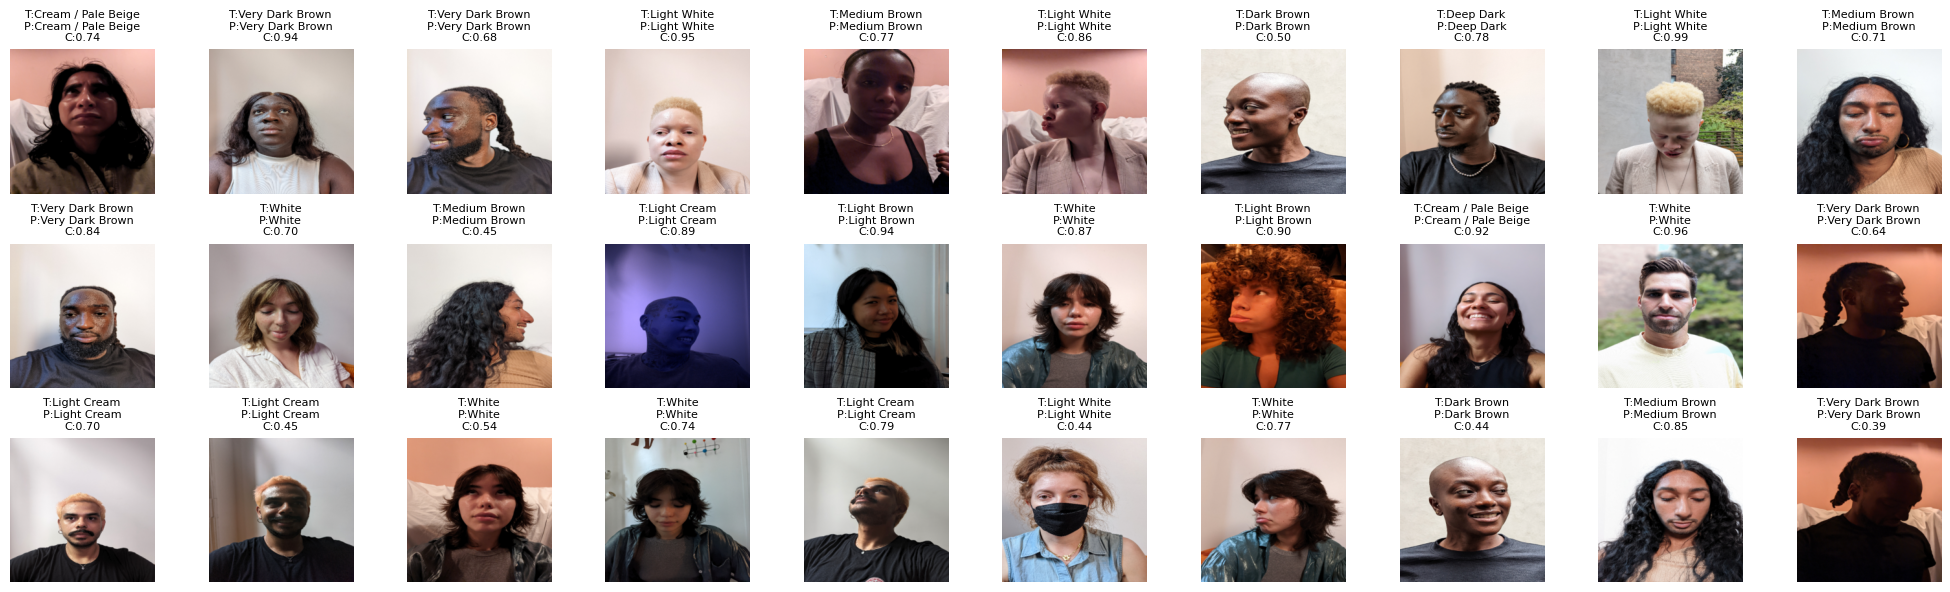

In [27]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

#trainer.prepare_data(data, one_hot_labels, split_ratio=0.8)
skin_tones = {
    0: "Light White",
    1: "White",
    2: "Light Cream",
    3: "Cream / Pale Beige",
    4: "Light Brown",
    5: "Medium Brown",
    6: "Brown",
    7: "Dark Brown",
    8: "Very Dark Brown",
    9: "Deep Dark"
}
all_images, all_labels = [], []

for images, labels in trainer.val_loader:
    all_images.append(images)
    all_labels.append(labels)
    if sum([img.shape[0] for img in all_images]) >= 30:
        break

images = torch.cat(all_images, dim=0)[:30]  
labels = torch.cat(all_labels, dim=0)[:30]


images = images.to(trainer.device)


with torch.no_grad():
    outputs = trainer.model(images).logits
    probs = torch.sigmoid(outputs)
    predicted_classes = torch.argmax(probs, dim=1)
    confidences = torch.max(probs, dim=1).values

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i in range(30):
    row, col = i // 10, i % 10
    img = images[i].cpu().permute(1,2,0).numpy()
    img = (img - img.min()) / (img.max() - img.min()) 
    axes[row, col].imshow(img)
    true_class = torch.argmax(labels[i]).item()
    axes[row, col].set_title(f"T:{skin_tones[true_class]}\nP:{skin_tones[predicted_classes[i].item()]}\nC:{confidences[i]:.2f}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


Data prepared — Train: 1208, Val: 302


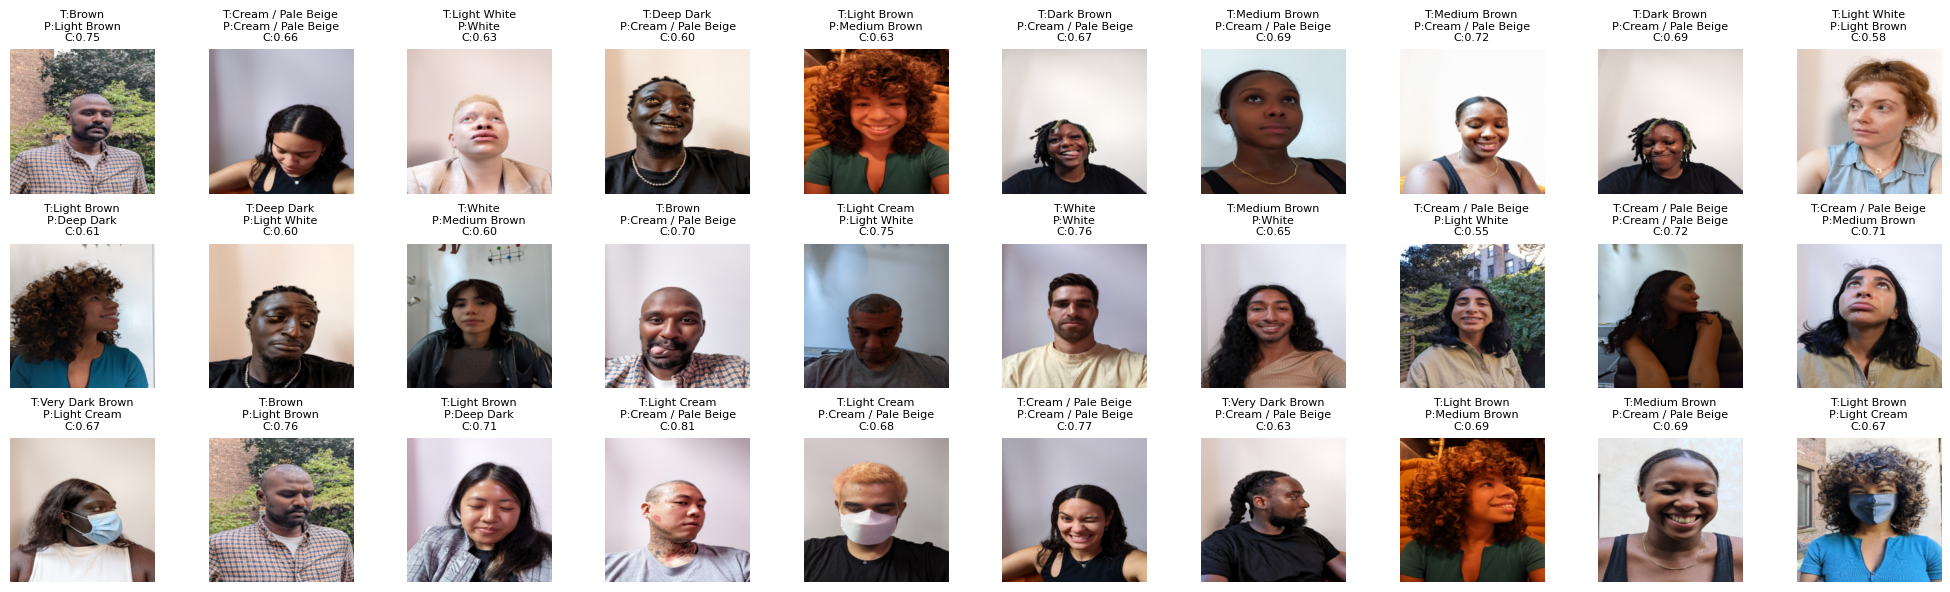

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image


skin_tones = {
    0: "Light White",
    1: "White",
    2: "Light Cream",
    3: "Cream / Pale Beige",
    4: "Light Brown",
    5: "Medium Brown",
    6: "Brown",
    7: "Dark Brown",
    8: "Very Dark Brown",
    9: "Deep Dark"
}

trainer.prepare_data(data, one_hot_labels, split_ratio=0.8)

all_images, all_labels = [], []

for images, labels in trainer.val_loader:
    all_images.append(images)
    all_labels.append(labels)
    if sum([img.shape[0] for img in all_images]) >= 30:
        break

images = torch.cat(all_images, dim=0)[:30] 
labels = torch.cat(all_labels, dim=0)[:30]


images = images.to(trainer.device)


with torch.no_grad():
    outputs = trainer.model(images).logits
    probs = torch.sigmoid(outputs)
    predicted_classes = torch.argmax(probs, dim=1)
    confidences = torch.max(probs, dim=1).values

fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i in range(30):
    row, col = i // 10, i % 10
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  
    axes[row, col].imshow(img)

    true_class = torch.argmax(labels[i]).item()
    pred_class = predicted_classes[i].item()
    confidence = confidences[i].item()

    # Get class names
    true_name = skin_tones.get(true_class, "Unknown")
    pred_name = skin_tones.get(pred_class, "Unknown")

    axes[row, col].set_title(
        f"T:{true_name}\nP:{pred_name}\nC:{confidence:.2f}", 
        fontsize=8
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()
